# Setting Up

### To be run through regardless of task.

Installing necessary libraries.

In [1]:
%%capture

%load_ext autoreload
%autoreload 2

!pip install torchmetrics
!pip install ml_collections
!pip install ninja
!pip install torch_utils

External imports.

In [2]:
import functools
import torch
import tqdm
import os
import sys
import random
import ml_collections
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

Importing drive and adjusting paths.

In [3]:
# if run remotely: import utils from github repo
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    if os.path.isdir('./diffusion_for_PAT/') == False:
        ! git clone https://github.com/sreemanti-dey/diffusion_for_PAT.git
    sys.path.append('./diffusion_for_PAT/')
    sys.path.append('./diffusion_for_PAT/models/')
    sys.path.append('./diffusion_for_PAT/op/')
# if run locally: add parent path
else:
    parent_dir = os.path.dirname(os.getcwd())
    sys.path.append(parent_dir)


Cloning into 'diffusion_for_PAT'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 56 (delta 0), reused 8 (delta 0), pack-reused 47
Receiving objects: 100% (56/56), 94.55 MiB | 22.93 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Internal imports.

In [4]:
import samplers
import ncsnpp
from samplers import pc_denoiser, pc_sampler
from sdes import Classic, VarianceExploding, VariancePreserving, SubVariancePreserving
from tasks import AddGaussianNoise, inpaint, gaussian_downsampling, PAT_forward
from metrics import PSNR, avg_PSNR, compare_PSNR, avg_SSIM
from misc_utils import plot_before_after, plot_samples, awgn, limited_view_rmd, spatial_alias_rmd

Necessary parameters for running the model.

In [5]:
# set random seed
random.seed(0)
torch.manual_seed(0)

# set device
device = 'cuda'         #@param ['cuda', 'cpu']

# synthetic vascular dataset for this demo
# pre-generated with Vascusynth
dataset = 'Vasc'

# set SDE; VP empirically good
sde_type = 'vp'        #@param ['classic', 'vp', 've', 'subvp']

# set necessary parameters depending on chosen SDE
if sde_type == "classic":
  param = 0.01 #@param {'type' : 'number'}
  sde_params = [param,]
else:
  param1 = 0.1 #@param {'type' : 'number'}
  param2 = 20 #@param {'type' : 'number'}
  sde_params = [param1, param2] # [classic: sigma][vp: b_min, b_max][ve|subve: s_min, s_max]

# choose sampling method in general
gen_sampler = 'pc'     #@param ['em', 'pc', 'ode']

# choose sampling method for reconstructing
# probably the same as gen_sampler
reconstructing_sampler = 'pc' #@param ['em', 'pc']

# training or reconstruction mode
training = False #@param {'type' : 'boolean'}
reconstructing = True #@param {'type' : 'boolean'}

In [6]:
# SDE
# Making relevant SDE objects
if sde_type == 've':
    SDE = VarianceExploding()
    sigma_min, sigma_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, sigma_min=sigma_min, sigma_max=sigma_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, sigma_min=sigma_min, sigma_max=sigma_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, sigma_min=sigma_min, sigma_max=sigma_max)
elif sde_type == 'vp':
    SDE = VariancePreserving()
    beta_min, beta_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, beta_min=beta_min, beta_max=beta_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
elif sde_type == 'subvp':
    SDE = SubVariancePreserving()
    beta_min, beta_max = sde_params
    params_str = '{}_{}'.format(*sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, beta_min=beta_min, beta_max=beta_max)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
elif sde_type == 'classic':
    SDE = Classic()
    sigma = sde_params
    params_str = '{}'.format(sde_params)
    marginal_prob_std_fn = functools.partial(SDE.marginal_prob_std, sigma=sigma)
    drift_coeff_fn = functools.partial(SDE.drift_coeff, sigma=sigma)
    diffusion_coeff_fn = functools.partial(SDE.diffusion_coeff, sigma=sigma)

# sampler for generation
if gen_sampler == 'em':
    sampler = samplers.Euler_Maruyama_sampler
elif gen_sampler == 'pc':
    sampler = samplers.pc_sampler
elif gen_sampler == 'ode':
    sampler = samplers.ode_sampler

# sampler for denoising
if reconstructing_sampler == 'em':
    denoiser = samplers.Euler_Maruyama_denoiser
elif reconstructing_sampler == 'pc':
    denoiser = samplers.pc_denoiser

# Training

### To be run if training new backbone model from scratch.

Dataset class for synthetic vascular images.

In [7]:
class Vasc_Dataset(Dataset):
  def __init__(self, filepath, transform=None):
    self.filepath = filepath
    self.transform = transform

  def __len__(self):
    return len(os.listdir(self.filepath))

  def __getitem__(self, idx):
    item = np.load(self.filepath + '/{}.npy'.format(idx))

    if self.transform:
      return self.transform(item)

    return item

Training parameters.

In [12]:
n_epochs = 1
batch_size = 8
lr = 1e-4

Make training dataset. First unzipping into folder then making loader.

In [9]:
%%capture
!unzip "/content/diffusion_for_PAT/datasets/Synthetic_Vascular_Dataset.zip" -d "/content/diffusion_for_PAT/datasets/Synthetic_Vascular_Dataset"

In [10]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.ConvertImageDtype(torch.float),
                                        transforms.Pad(14)])
train_dataset = Vasc_Dataset('diffusion_for_PAT/datasets/Synthetic_Vascular_Dataset', transform=train_transforms);
nw = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

Loss function.

In [11]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps

    z = torch.randn_like(x)
    mean_x, std = marginal_prob_std(x, random_t)

    perturbed_x = mean_x + std[:, None, None, None] * z

    score = model(perturbed_x, random_t)

    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))

    return loss

Set checkpoint directory path.

In [13]:
# checkpoint folder varies if on colab or local
if IN_COLAB:
    checkpoint_dir = './diffusion_for_PAT/checkpoints/'
else:
    checkpoint_dir = './checkpoints/'

Model configuration.

In [14]:
def get_config():
  config = ml_collections.ConfigDict()
  config.training = training = ml_collections.ConfigDict()
  training.sde = 'vpsde'
  training.likelihood_weighting = False
  training.importance_weighting = False
  training.continuous = True
  training.reduce_mean = False

  config.model = model = ml_collections.ConfigDict()
  model.name = 'ncsnpp'
  model.num_scales = 1000
  model.sigma_min = 0.002
  model.sigma_max = 50.
  model.beta_min = sde_params[0]
  model.beta_max = sde_params[1]
  model.dropout = 0.1
  model.scale_by_sigma = False
  model.ema_rate = 0.9999
  model.normalization = 'GroupNorm'
  model.nonlinearity = 'swish'
  model.nf = 64  # 128
  model.ch_mult = (1, 2, 2, 2)  # (1, 1, 2, 2, 4, 4)
  model.num_res_blocks = 4  # 2
  model.attn_resolutions = (16,)
  model.resamp_with_conv = True
  model.conditional = True
  model.fir = True
  model.fir_kernel = [1, 3, 3, 1]
  model.skip_rescale = True
  model.resblock_type = 'biggan'
  model.progressive = 'none'
  model.progressive_input = 'residual'
  model.progressive_combine = 'sum'
  model.attention_type = 'ddpm'
  model.embedding_type = 'positional'
  model.init_scale = 0.
  model.fourier_scale = 16
  model.conv_size = 3
  model.interpolation = 'bilinear'  # NCSNv2

  config.data = data = ml_collections.ConfigDict()
  data.image_size = 128
  data.num_channels = 1
  data.centered = False
  return config

Training loop and visualization.

In [ ]:
score_model = torch.nn.DataParallel(ncsnpp.NCSNpp(get_config()))
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)

# name the model
checkpoint_path = checkpoint_dir + 'ckpt_demo_test.pth'

epoch_losses = []
tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in train_loader:
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    epoch_losses.append(avg_loss / num_items)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    if epoch % 10 == 0:
      torch.save(score_model.state_dict(), checkpoint_path)

In [ ]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Load Model

### To be run if not training from scratch.

In [17]:
score_model = torch.nn.DataParallel(ncsnpp.NCSNpp(get_config()))
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)

checkpoint_path = checkpoint_dir+'ckpt_ncsnpp_50epochs_vp_0.1_20.pth'

score_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

# Unconditional Sampling

Running the sampler and visualizing results.

In [ ]:
# Can easily vary number of generated images (first arg)
# Other args mostly based on previous choices

gen_imgs = pc_sampler(16,
                      score_model,
                      im_size=100,
                      idf=14,
                      marginal_prob_std=marginal_prob_std_fn,
                      diffusion_coeff=diffusion_coeff_fn,
                      drift_coeff=drift_coeff_fn)

  0%|          | 0/500 [00:00<?, ?it/s]

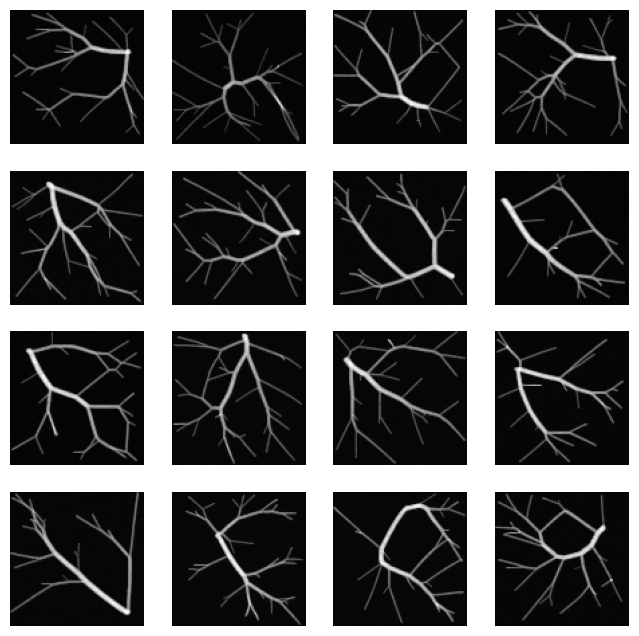

In [ ]:
plot_samples(gen_imgs)

# Conditional Reconstructions

Specifying PAT parameters.

In [18]:
# PAT parameters
# --------------

# Fixed parameters

# radius of ring
R_ring         = 0.11

# image height in pixels
M              = 100

# image width in pixels
N              = 100

# speed of sound m/s
V_sound        = 1500

# pixel size in meters
px             = 1e-3
py             = 1e-3

# Free parameters

# number of transducers
N_transducer   = 100

# sampling interval in seconds
dt = 0.5e-6

center_freq   = 0.5e6 #2.25e6 in real experimental setting
fwhm       = 0.5e6 #2.16e6 in real experimental setting

# half the major diagonal of the fov
Diag = np.sqrt((py * (M / 2 - 0.5))**2 + (px * (N / 2 - 0.5))**2)

# minimum time for sound to travel from the fov to the ring
T_min = (R_ring - Diag) / V_sound

# max time for sound to travel from any point in the fov to the ring
T_max = (R_ring + Diag) / V_sound

T_max_n = round(T_max/dt)
T_min_n = round(T_min/dt)
T_min = T_min_n * dt

# number of samples per transducers, need N_sample * dt to cover the interval
# from T_min to T_max
N_sample = T_max_n - T_min_n + 1

# increasing oversampling makes more accurate forward matrix
# gets rid of aliasing
oversample  = 10

# padding for filtering, increase to make more accurate forward matrix
padsample   = 50

# receiving bandwidth of transducer array in Hz
Band        = 1 /dt / 2

# PAT_config=[N_transducer, R_ring, px, py, M, N, dt, N_sample, oversample, padsample, T_min, Band, V_sound]
PAT_config=[N_transducer, R_ring, px, py, M, N, dt, N_sample, oversample, padsample, T_min, center_freq, fwhm, V_sound]

Paths to forward matrices, measurements, and test images.

In [20]:
test_GT_path = './diffusion_for_PAT/GT/'
test_path = './diffusion_for_PAT/PAT_measurements/'
A_path = './diffusion_for_PAT/forward_matrices/'
save_path = './diffusion_for_PAT/saved_reconstructions/'

GT_test = torch.load(test_GT_path + 'GT_test.pt')

## Limited View

Loading a forward matrix and measurements. Otherwise, generating new measurements and A from scratch.

In [21]:
measurements_name = 'PAT_LV_50_test.pt'
A_name = 'A_50.pt'

# load saved forward matrix and measurements
if os.path.exists(test_path + measurements_name) and os.path.exists(A_path + A_name):
  PAT_LV_50_measurements = torch.load(test_path + measurements_name)
  A_50 = torch.load(A_path + A_name)
# otherwise train from scratch
else:
  rmd = limited_view_rmd(100, 50)

  PAT_LV_50_measurements, P, L, T = PAT_forward(GT_test, PAT_config, add_noise=True, remove_transducers=True, removed_transducers=rmd)
  A_50 = torch.matmul(torch.matmul(P, L), T)

  torch.save(PAT_LV_50_measurements, test_path + measurements_name)
  torch.save(A_50, A_path + A_name)

[100, 100, 100, 3860]

100%|██████████| 100/100 [09:28<00:00,  5.68s/it]


Running reconstruction and visualizing.

In [ ]:
recon_50, _, _, = pc_denoiser(PAT_LV_50_measurements.to(device),
                              score_model,
                              im_size=100,
                              idf=14,
                              lbda=0.99999995,
                              marginal_prob_std=marginal_prob_std_fn,
                              diffusion_coeff=diffusion_coeff_fn,
                              drift_coeff=drift_coeff_fn,
                              forward_A=A_50.to(device),
                              clean_images=GT_test.to(device))

# torch.save(recon_50.squeeze(), save_path + 'LV_50_recons.pt')

  0%|          | 0/500 [00:00<?, ?it/s]

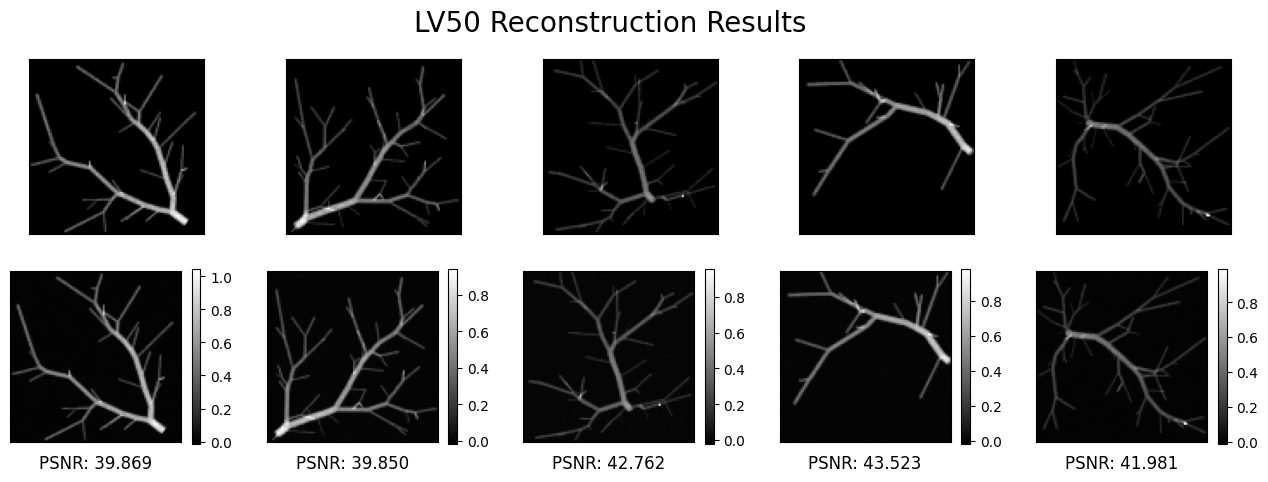

In [ ]:
plot_before_after(GT_test[0:5].unsqueeze(1),
                  GT_test[0:5].unsqueeze(1),
                  recon_50[0:5],
                  title="LV50 Reconstruction Results")

In [ ]:
print("Average PSNR on LV50: ", avg_PSNR(GT_test, recon_50.squeeze())[0])

Average PSNR on LV50:  41.540874813855545


## Spatial Aliasing

In [ ]:
measurements_name = 'PAT_SA_33_test.pt'
A_name = 'A_SA_33.pt'

# load saved forward matrix and measurements
if os.path.exists(test_path + measurements_name) and os.path.exists(A_path + A_name):
  PAT_SA_33_measurements = torch.load(test_path + measurements_name)
  A_SA_33 = torch.load(A_path + A_name)
# otherwise train from scratch
else:
  rmd = spatial_alias_rmd(100, 3)

  PAT_SA_33_measurements, P, L, T = PAT_forward(GT_test, PAT_config, add_noise=True, remove_transducers=True, removed_transducers=rmd)
  A_SA_33 = torch.matmul(torch.matmul(P, L), T)

  torch.save(PAT_SA_33_measurements, test_path + measurements_name)
  torch.save(A_SA_33, A_path + A_name)

[100, 100, 100, 3860]

100%|██████████| 100/100 [08:58<00:00,  5.39s/it]


In [ ]:
recon_SA_33, _, _, = pc_denoiser(PAT_SA_33_measurements.to(device),
                                 score_model,
                                 im_size=100,
                                 idf=14,
                                 lbda=0.999999,
                                 marginal_prob_std=marginal_prob_std_fn,
                                 diffusion_coeff=diffusion_coeff_fn,
                                 drift_coeff=drift_coeff_fn,
                                 forward_A=A_SA_33.to(device),
                                 clean_images=GT_test.to(device))

# torch.save(recon_SA_33.squeeze(), save_path + 'SA_33_recons.pt')

  0%|          | 0/500 [00:00<?, ?it/s]

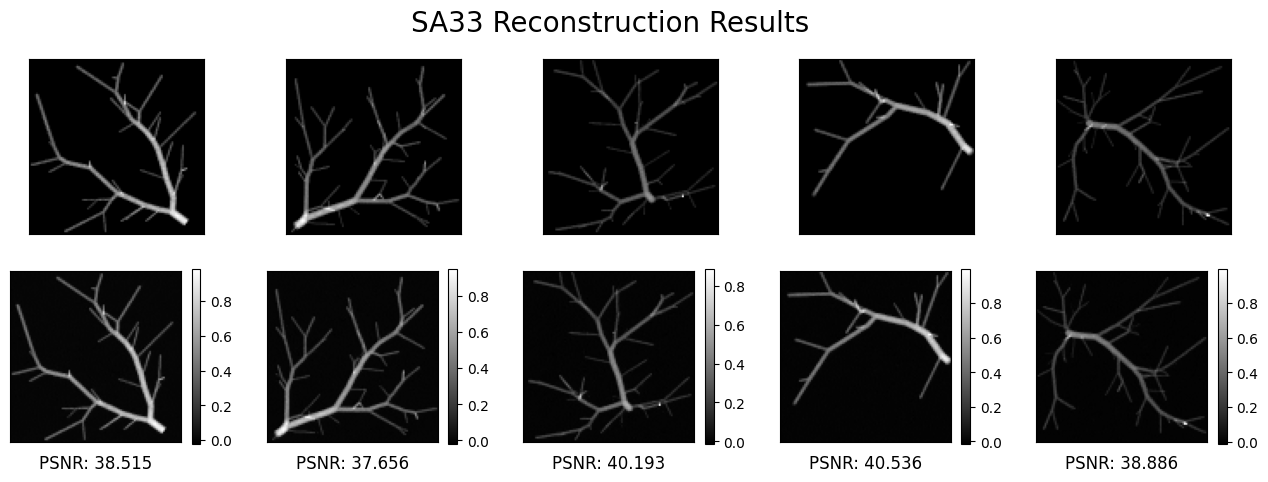

In [ ]:
plot_before_after(GT_test[0:5].unsqueeze(1),
                  GT_test[0:5].unsqueeze(1),
                  recon_SA_33[0:5],
                  title="SA33 Reconstruction Results")

In [ ]:
print("Average PSNR on SA33: ", avg_PSNR(GT_test, recon_SA_33.squeeze())[0])

Average PSNR on SA33:  39.823710323873335


# Breast Image

Load GT for breast image and measurements.

In [25]:
GT_breast = torch.load(test_GT_path + 'GT_breast.pt')

In [28]:
PAT_LV_50_breast = torch.load(test_path + 'PAT_LV_50_breast.pt')

Run reconstruction.

In [29]:
breast_recon_lv50, _, _, = pc_denoiser(PAT_LV_50_breast.to(device),
                                       score_model,
                                       im_size=100,
                                       idf=14,
                                       lbda=0.99999995,
                                       marginal_prob_std=marginal_prob_std_fn,
                                       diffusion_coeff=diffusion_coeff_fn,
                                       drift_coeff=drift_coeff_fn,
                                       forward_A=A_50.to(device),
                                       clean_images=GT_breast.to(device))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/500 [00:00<?, ?it/s]

Visualization.

PSNR:  23.702591899365405


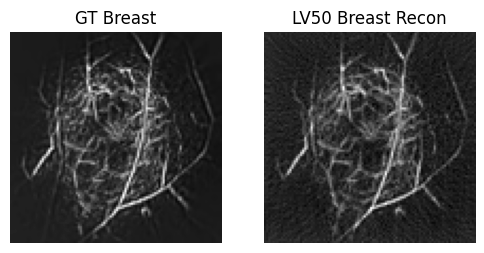

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(6, 12))

axs[0].imshow(GT_breast[0].squeeze(), cmap='gray')
axs[0].set_title("GT Breast")
axs[0].axis('off')

axs[1].imshow(breast_recon_lv50[0].squeeze().cpu().numpy(), cmap='gray')
axs[1].set_title("LV50 Breast Recon")
axs[1].axis('off')

print("PSNR: ", PSNR(GT_breast[0].squeeze(), breast_recon_lv50[0].squeeze().cpu()))